# Formatted Zone (Audio)

This notebook contains the scripts needed for the extraction of audio from the formatted zone, its processing and cleaning of the data and storage to the trusted Zone. The trusted zone is represented by another bucket and aims to replicate the same folder structure as the formatted zone. The difference is that the data has been processed and transform in order to clean and ensure a clean audios.

This notebook focuses only on audio (the equivalent notebooks for the other types of data can be found in the same folder). Particularly, the following scripts are responsible of the following tasks:

Extraction of audios from formatted zone. Treatment of the data, to ensure data quality.

First, we will connect to MinIO and prepare the new bucket:

In [4]:
import boto3
import os
from dotenv import load_dotenv

load_dotenv()
access_key_id = os.getenv("ACCESS_KEY_ID")
secret_access_key = os.getenv("SECRET_ACCESS_KEY")
minio_url = "http://" + os.getenv("S3_API_ENDPOINT")


minio_client = boto3.client(
    "s3",
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    endpoint_url=minio_url
)

new_bucket = "trusted-zone"
try:
    minio_client.create_bucket(Bucket=new_bucket)
except (minio_client.exceptions.BucketAlreadyExists, minio_client.exceptions.BucketAlreadyOwnedByYou):
    print(f"Bucket '{new_bucket}' already exists")

Bucket 'trusted-zone' already exists


In [5]:
def detectar_filtro(centroid, rolloff, ratio):
    if centroid < 1500 and rolloff < 3000 and ratio < 0.5:
        return "Low-pass filter"
    elif centroid > 4000 and rolloff > 6000 and ratio > 1.5:
        return "High-pass filter"
    elif 1500 <= centroid <= 4000 and 3000 <= rolloff <= 6000 and 0.5 <= ratio <= 1.5:
        return "Band-pass filter"
    else:
        return "No filter"

In [6]:
# DO THE ANALYSIS OF ALL THE AUDIO FILES.
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import math
import pandas as pd
from pydub import AudioSegment
from pydub.silence import detect_silence

def analyze_audio_file(audio_bytes):
    """
    This function analyzes all audio files in the Formatted Zone and stores the results in a JSON file.
    """
    # Get all audio files from the Formatted Zone
    
    audio = AudioSegment.from_file(BytesIO(audio_bytes))
    
    # ---- BASIC INFORMATION ----
    
    duration = len(audio) / 1000        # DURATION IN SECONDS.
    frame_rate = audio.frame_rate       # SAMPLING FREQUENCY.
    channels = audio.channels           # CHANNELS.
    sample_width = audio.sample_width   # SAMPLING WIDTH IN BYTES. IF WE WANT IT IN BITS MULTIPLY BY 8.
    
    # ---- SOUND & VOLUME INFORMATION ----
    
    rms = audio.rms
    audio_level = 20 * math.log10(rms) if rms > 0 else -float('inf')    #RMS CONVERSION TO DECIBELS.
    peak = audio.max                                                    # PEAK VOLUME.
    noise_floor = audio.dBFS                                            # NOISE FLOOR.
    
    # ---- DETECT SILENCE ----
    
    silence_ranges = detect_silence(audio, min_silence_len=500, silence_thresh=-50)     # DETECT SILENCES.
    total_silence_duration = sum(end - start for start, end in silence_ranges) / 1000   # CONVERT TO SECONDS.
    silence_percent = (total_silence_duration / duration) * 100 if duration > 0 else 0  # PERCENTAGE OF SILENCE.
    
    # ---- DYNAMIC RANGE ----
    dynamic_range = peak - rms
    
    # ---- HIGH-PASS & LOW-PASS FILTERS ----
    
    "This section analyzes an audio file to determine whether it has a low-pass, high-pass, or band-pass filter applied."
    "It converts the audio into numerical data, measures how the energy is distributed across low and high"
    "frequencies, and based on that distribution, classifies the type of filter that appears to be present."
    
    samples = np.array(audio.get_array_of_samples()).astype(np.float32)                 # GET SAMPLES.

    if channels == 2:                                                                   # IF CHANEL IS ESTEREO WE CONVERT TO MONO.
        samples = samples.reshape((-1, 2))
        samples = np.mean(samples, axis=1)
        
    samples /= np.iinfo(audio.array_type).max                                          # NORMALIZE SAMPLES.
    sr = audio.frame_rate                                                               # GET SAMPLING RATE.
    
    
    centroid = librosa.feature.spectral_centroid(y=samples, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=samples, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=samples, sr=sr, roll_percent=0.95)

    S = np.abs(librosa.stft(samples))
    freqs = librosa.fft_frequencies(sr=sr)

    low_energy = np.sum(S[(freqs > 0) & (freqs < 1000)])
    high_energy = np.sum(S[freqs > 5000])
    ratio = high_energy / (low_energy + 1e-9)

    # GLOBAL AVERAGES
    centroid_mean = np.mean(centroid)
    bandwidth_mean = np.mean(bandwidth)
    rolloff_mean = np.mean(rolloff)
    
    # FILTER DETECTION
    filter_type = detectar_filtro(centroid_mean, rolloff_mean, ratio)
    
    return {
        "duration": duration,
        "frame_rate": frame_rate,
        "channels": channels,
        "sample_width": sample_width,
        "audio_level": audio_level,
        "peak": peak,
        "noise_floor": noise_floor,
        "silence_ranges": silence_ranges,
        "total_silence_duration": total_silence_duration,
        "silence_percent": silence_percent,
        "dynamic_range": dynamic_range,
        "filter_type": filter_type
    }

Here we process the original audio files to detect any anomalies or irregularities.

The main objective is to evaluate key audio characteristics such as overall level, peak amplitude, noise floor, and dynamic range. We also aim to determine whether any filters (such as high-pass or low-pass) have been applied to the audio.

In this stage, we perform a detailed analysis of the raw audio files and then apply a series of treatments to remove noise and other unwanted artifacts.

Finally, the cleaned audio files are stored in the Trusted Zone, and a post-processing analysis is carried out to verify that the anomalies have been properly corrected and eliminated.

In [9]:
from tqdm import tqdm
analysis_results = []
bucket_origen = "formatted-zone"
prefix_origen = "audio/"

paginator = minio_client.get_paginator("list_objects_v2")

for page in paginator.paginate(Bucket=bucket_origen, Prefix=prefix_origen):
    for obj in tqdm(page.get("Contents", []), desc="Processant àudios"):
        key = obj["Key"]
        filename = key.split("/")[-1]

        #Read original audio
        response = minio_client.get_object(Bucket=bucket_origen, Key=key)
        audio_data = response["Body"].read()
        analysis_results.append(analyze_audio_file(audio_data))
        
df = pd.DataFrame(analysis_results)
df.head()

Processant àudios:   0%|          | 0/100 [00:00<?, ?it/s]

Processant àudios: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


,duration,frame_rate,channels,sample_width,audio_level,peak,noise_floor,silence_ranges,total_silence_duration,silence_percent,dynamic_range,filter_type
0,1.602,22050,1,2,75.102245,31135,-15.206753,[],0.0,0.0,25445,No filter
1,3.738,22050,1,2,73.449346,30471,-16.859652,[],0.0,0.0,25767,No filter
2,5.294,22050,1,2,71.758707,30961,-18.550292,[],0.0,0.0,27089,No filter
3,3.518,22050,1,2,70.984971,31560,-19.324028,[],0.0,0.0,28018,No filter
4,1.939,22050,1,2,74.865490,30730,-15.443508,[],0.0,0.0,25193,No filter


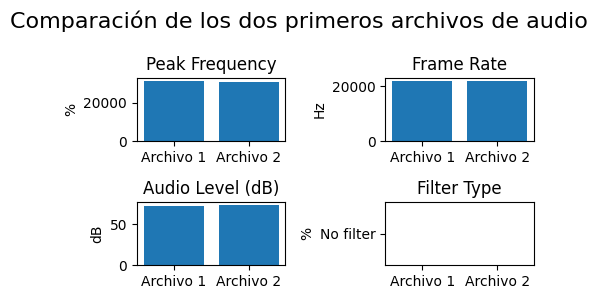

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Select the first two files
# we select two random

primeros_dos = df.sample(n=2, random_state=42)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(5, 3))
fig.suptitle('Comparación de los dos primeros archivos de audio', fontsize=16)

axes[0,0].bar(['Archivo 1', 'Archivo 2'], primeros_dos['peak'])
axes[0,0].set_title('Peak Frequency')
axes[0,0].set_ylabel('%')

axes[0,1].bar(['Archivo 1', 'Archivo 2'], primeros_dos['frame_rate'])
axes[0,1].set_title('Frame Rate')
axes[0,1].set_ylabel('Hz')

# Plot 2: Audio levels
axes[1,0].bar(['Archivo 1', 'Archivo 2'], primeros_dos['audio_level'])
axes[1,0].set_title('Audio Level (dB)')
axes[1,0].set_ylabel('dB')

axes[1,1].bar(['Archivo 1', 'Archivo 2'], primeros_dos['filter_type'])
axes[1,1].set_title('Filter Type')
axes[1,1].set_ylabel('%')

plt.tight_layout()
plt.show()

This script is responsible for extracting audio files from the Formatted Zone, processing and cleaning them to ensure their quality, and finally storing them in the Trusted Zone. The process begins by reading all audio files from the formatted-zone bucket and then applying several treatments to enhance their quality.

First, it normalizes the sampling rate to 44.1 kHz to ensure compatibility and consistent quality across all audio files. Then, it detects and removes long silences at the beginning and end of the files using a threshold of –50 decibels and a minimum duration of 500 milliseconds, which improves storage efficiency.

Next, it equalizes the volume levels of all audio files to ensure consistency during playback and applies dynamic compression with a threshold of –20 decibels and a 4:1 ratio to balance dynamic levels and enhance clarity and presence.

The process also includes quality filters: a high-pass filter at 80 Hz to remove low-frequency noise and a low-pass filter at 16 kHz to eliminate high-frequency noise. Finally, it increases the gain by 2 decibels to improve the presence of the audio and optimize it for playback.

The final result is a set of processed audio files with 192 kbps optimized MP3 quality, completely clean, without unwanted noise or silences, while preserving the original folder structure when stored in the Trusted Zone.

In [ ]:
from pydub import AudioSegment
from pydub.effects import normalize, compress_dynamic_range
from pydub.silence import split_on_silence, detect_silence
import io
from tqdm import tqdm

bucket_origen = "formatted-zone"
bucket_desti = "trusted-zone"
prefix_origen = "audio/"
freq_final = 48000

paginator = minio_client.get_paginator("list_objects_v2")

for page in paginator.paginate(Bucket=bucket_origen, Prefix=prefix_origen):
    for obj in tqdm(page.get("Contents", []), desc="Processant àudios"):
        key = obj["Key"]
        filename = key.split("/")[-1]

        #read original audio
        response = minio_client.get_object(Bucket=bucket_origen, Key=key)
        audio_data = response["Body"].read()

        #open with pydub
        try:
            audio = AudioSegment.from_file(io.BytesIO(audio_data), format="mp3")
        except Exception as e:
            print(f"Error amb {filename}: {e}")
            continue

        # APPLY CLEANING AND IMPROVEMENT TREATMENTS
        
        # 1. Normalize sampling frequency
        audio = audio.set_frame_rate(freq_final)
        
        # 2. Clean silences at the beginning and end
        # Detect and remove long silences at the beginning and end
        silence_threshold = -50  # dB
        silence_duration = 500   # ms
        
        # Detect silence
        silence_ranges = detect_silence(audio, min_silence_len=silence_duration, silence_thresh=silence_threshold)
        
        if silence_ranges:
            # Remove silence at the end
            if silence_ranges[-1][1] > len(audio) - 1000:  # If the last silence is near the end
                audio = audio[:silence_ranges[-1][0]]
            
            # Remove silence at the beginning
            if silence_ranges[0][0] < 1000:  # If the first silence is near the beginning
                audio = audio[silence_ranges[0][1]:]
        
        # Normalize volume (equalize levels)
        audio = normalize(audio)
        
        # Dynamic compression to balance levels
        audio = compress_dynamic_range(audio, threshold=-20.0, ratio=4.0, attack=5.0, release=50.0)
        
        # Noise filter (reduce background noise)
        # Apply a very soft high-pass filter to eliminate low-frequency noise
        audio = audio.high_pass_filter(80)  # Hz
        
        # Noise filter (reduce high-frequency noise)
        # Apply a low-pass filter to eliminate high-frequency noise
        audio = audio.low_pass_filter(16000)  # Hz
        
        # Final volume normalization
        audio = normalize(audio)
        
        # Final gain adjustment (optional: +2dB for more presence)
        audio = audio + 2

        # Save as MP3 and upload to formatted-zone bucket
        buffer = io.BytesIO()
        audio.export(buffer, format="mp3", bitrate="192k")
        buffer.seek(0)

        new_key = f"audio/{filename}"
        minio_client.put_object(
            Bucket=bucket_desti,
            Key=new_key,
            Body=buffer
        )

Processant àudios: 100%|██████████| 100/100 [4:19:51<00:00, 155.91s/it]   


Here we evaluate the final audio files to verify the results of the treatment.
The goal is to determine whether the applied processing has successfully resolved the main issues previously detected in the audio.
This means that the anomalies identified earlier have now been removed, and we can confirm that the audio stored in the Trusted Zone is clean, consistent, and ready for further use.

In [ ]:

analysis_results_2 = []
bucket_origen = "trusted-zone"
prefix_origen = "audio/"

paginator = minio_client.get_paginator("list_objects_v2")

for page in paginator.paginate(Bucket=bucket_origen, Prefix=prefix_origen):
    for obj in tqdm(page.get("Contents", []), desc="Processant àudios"):
        key = obj["Key"]
        filename = key.split("/")[-1]

        #Llegir àudio original
        response = minio_client.get_object(Bucket=bucket_origen, Key=key)
        audio_data = response["Body"].read()
        analysis_results_2.append(analyze_audio_file(audio_data))
        
df2 = pd.DataFrame(analysis_results_2)
df2.head()

Processant àudios:   0%|          | 0/100 [00:00<?, ?it/s]

Processant àudios: 100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


,duration,frame_rate,channels,sample_width,audio_level,peak,noise_floor,silence_ranges,total_silence_duration,silence_percent,dynamic_range,filter_type
0,1.567,44100,1,2,77.628834,31909,-12.680164,[],0.0,0.0,24298,No filter
1,3.506,44100,1,2,76.509821,31999,-13.799178,[],0.0,0.0,25308,No filter
2,5.445,44100,1,2,76.234181,31923,-14.074818,[],0.0,0.0,25441,No filter
3,3.669,44100,1,2,75.218999,31902,-15.090000,[],0.0,0.0,26135,No filter
4,1.811,44100,1,2,76.732811,31943,-13.576188,[],0.0,0.0,25078,No filter


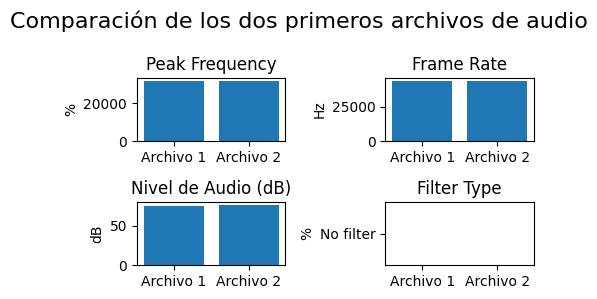

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Seleccionar los dos primeros archivos
# cogemos dos aleatorios

primeros_dos = df2.sample(n=2, random_state=42)

# Crear subplots
fig, axes = plt.subplots(2, 2, figsize=(5, 3))
fig.suptitle('Comparación de los dos primeros archivos de audio', fontsize=16)

axes[0,0].bar(['Archivo 1', 'Archivo 2'], primeros_dos['peak'])
axes[0,0].set_title('Peak Frequency')
axes[0,0].set_ylabel('%')

axes[0,1].bar(['Archivo 1', 'Archivo 2'], primeros_dos['frame_rate'])
axes[0,1].set_title('Frame Rate')
axes[0,1].set_ylabel('Hz')

# Plot 2: Niveles de audio
axes[1,0].bar(['Archivo 1', 'Archivo 2'], primeros_dos['audio_level'])
axes[1,0].set_title('Nivel de Audio (dB)')
axes[1,0].set_ylabel('dB')

axes[1,1].bar(['Archivo 1', 'Archivo 2'], primeros_dos['filter_type'])
axes[1,1].set_title('Filter Type')
axes[1,1].set_ylabel('%')

plt.tight_layout()
plt.show()

It is worth noting that the audio files we receive, as with the other data formats, generally follow a homogeneous structure and exhibit very few anomalies. However, this is not always guaranteed we may not always receive clean and consistent audio files.

Therefore, even though in this particular case we observe only minor differences between the original and the processed audio files, the cleaning function will still be executed. This step is crucial to ensure that, regardless of the quality or consistency of the incoming files, all audio data undergoes a standardized treatment process to maximize clarity, uniformity, and reliability of the information.